# Characterizing the detector before we send it

In [1]:
% Helper functions for extraction FAR, etc.
function acc = EvalAccuracy(t, y, l)
    DetectTimes = Detection2List(t, y>0.5);
    DetectTimes = [ones(size(DetectTimes,1),1) DetectTimes];
    
    LabelTimes = Detection2List(t, l);
    LabelTimes = [ones(size(LabelTimes, 1), 1) LabelTimes];

    Durations = t(end);
    
    acc = DetectPerformance( DetectTimes(:, 2:end), ...
                             LabelTimes(:, 2:end), ...
                             Durations);
end

In [5]:
ramp_operator_setup;

%% detector
gain=1;

load('nnThud.mat', 'nnThud');
load('nnZCR.mat', 'nnZCR');

[Chain_declareThud, Chain_declareShatter] = gb_model_2020_09_09(ramp, gain, nnThud, nnZCR);
Chain = Chain_declareShatter > ramp.pin.A3();

In [4]:
% Load Test clip
[x, Fs] = audioread('GB_TestClip_v1_16000_mixed_included.wav');
t = (0 : length(x)-1) / Fs;

% And labels file
label_start_stop = csvread('GB_TestClip_v1_label_mixed_included.csv');
labels = 1.0 * List2Detections(t, label_start_stop);

In [9]:
% Test using modelChain
ramp_detections = modelChain(Chain, t, x);
accuracy_using_operator_model = EvalAccuracy(t, ramp_detections, labels)

accuracy_using_operator_model =

# of false triggers: 26; Events missed (%): 14
Average event latency (s): 0.0092994



In [ ]:
% Test using eval
ramp_detections = Chain(t, x);
accuracy_using_operator_eval = EvalAccuracy(t, ramp_detections, labels)

The results screen shot from prep notebook

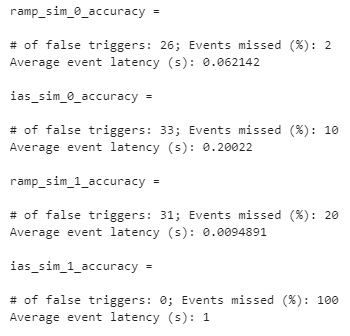

Running the eval from Matlab

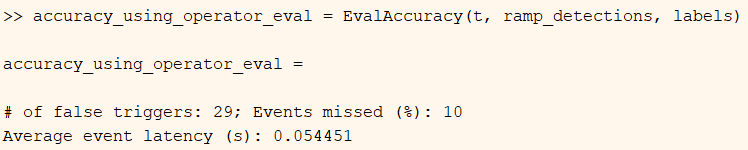

Checking the output of the Linux bundled detector

In [6]:
stdout = fileread('detections_linux.txt');

triggersCell = regexp(stdout, 'Event trigger from ([.0-9]*)s to ([.0-9]*)s', 'tokens');
triggers = [];
for j = 1 : length(triggersCell)
    triggers(j, 1) = str2num(triggersCell{j}{1});
    triggers(j, 2) = str2num(triggersCell{j}{2});
end
t = (0 : length(x)-1) / Fs;
detection_signal = 1.0 * List2Detections(t, triggers);
accuracy_using_linux_build = EvalAccuracy(t, detection_signal, labels)

accuracy_using_linux_build =

# of false triggers: 29; Events missed (%): 22
Average event latency (s): 0.0096298



Checking the output of the Windows bundled detector

In [7]:
stdout = fileread('detections_windows.txt');

triggersCell = regexp(stdout, 'Event trigger from ([.0-9]*)s to ([.0-9]*)s', 'tokens');
triggers = [];
for j = 1 : length(triggersCell)
    triggers(j, 1) = str2num(triggersCell{j}{1});
    triggers(j, 2) = str2num(triggersCell{j}{2});
end
t = (0 : length(x)-1) / Fs;
detection_signal = 1.0 * List2Detections(t, triggers);
accuracy_using_windows_build = EvalAccuracy(t, detection_signal, labels)

accuracy_using_windows_build =

# of false triggers: 31; Events missed (%): 20
Average event latency (s): 0.0094891



# Summary

```
| New Matlab Eval    | 10      | 29     | 54           |
| Method                  | FRR (%) | FA (#) | Latency (ms) |
|-------------------------|---------|--------|--------------|
| Old                     | 2       | 26     | 62           |
| New                     | 14      | 26     | 9.299        |
| New Bundled for Windows | 20      | 31     | 9.489        |
| New Bundled for Linux   | 22      | 29     | 9.629        |
| New bundle fix          | 16      | 19     | 8.88         |
```

In [8]:
audiowrite('labels.wav',labels,Fs);

# Notes
- Why is bundled different?
- Longer hold time to enable IFX to trigger
- Are the glass breaks in test file too close together? Madhu

# Why is the bundled different?

First, let's replicate the bundled one by applying the 1/5 gain in the build and then scaling the audio signal up. Theory is that the difference could be the zero-crossing rate.

In [19]:
ramp_operator_setup;

%% detector
gain=1;

load('nnThud.mat', 'nnThud');
load('nnZCR.mat', 'nnZCR');

[Chain_declareThud, Chain_declareShatter] = gb_model_2020_09_09(ramp, gain, nnThud, nnZCR);
Chain_matchBundle =  Chain_declareShatter > ramp.pin.A3();

In [20]:
% The existing chain: 14% FRR, 26 FAs, 9.299ms
% W/ 1/5 gain: 16% FRR,  15 FAs, 10.61ms
% W/ 1/5 gain & 5x scale up at input: 20% FRR, 31 FAs, 9.53ms
% The existing chain w/ 1/5 scale down at input: 22% FRR, 14 FAs, 11.3ms
ramp_detections = modelChain(Chain_matchBundle, t, x*1/5);
accuracy_trying_to_match = EvalAccuracy(t, ramp_detections, labels)

accuracy_trying_to_match =

# of false triggers: 14; Events missed (%): 22
Average event latency (s): 0.01138



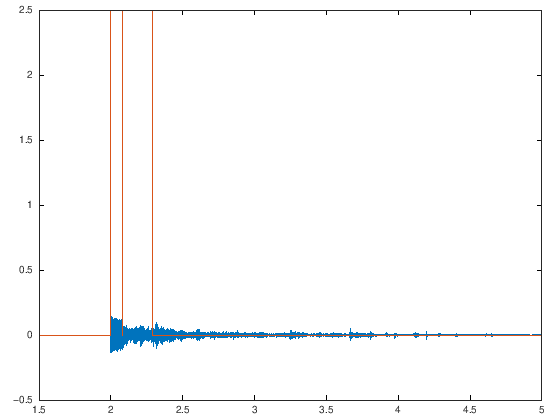

In [21]:
nD=find(t>1.5 & t<5);
plot(t(nD), x(nD), t(nD), ramp_detections(nD));

The bundled is different because we had a different signal scale going into the ZCR. 

# What about adding overhang to hold for longer?

accuracy_trying_to_match =

# of false triggers: 17; Events missed (%): 12
Average event latency (s): 0.0084702



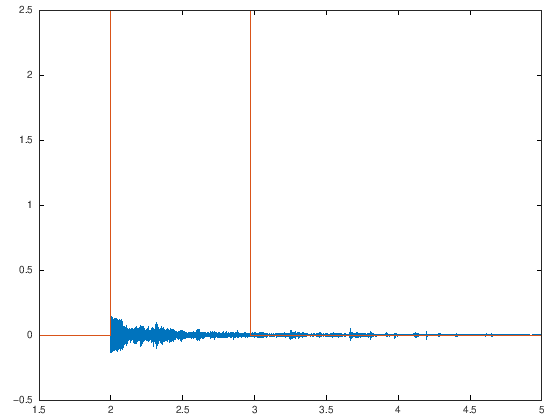

In [23]:
ramp_operator_setup;

%% detector
gain=1;

load('nnThud.mat', 'nnThud');
load('nnZCR.mat', 'nnZCR');

[Chain_declareThud, Chain_declareShatter] = gb_model_2020_09_09(ramp, gain, nnThud, nnZCR);
Chain_matchBundle =  Chain_declareShatter ...
                     > ramp.ops.overhang('up',1e3, 'down',3) ...
                     > ramp.ops.cmp('thresh',.3,'printTimeStamp',1) ...
                     > ramp.pin.A3();
ramp_detections = modelChain(Chain_matchBundle, t, x);
accuracy_trying_to_match = EvalAccuracy(t, ramp_detections, labels)
nD=find(t>1.5 & t<5);
plot(t(nD), x(nD), t(nD), ramp_detections(nD));

In [24]:
% Keep sections
tkeep = [0 43.55; ...
         52.929 55.172; ...
         74.724 75.884; ...
         80.635 82.620; ...
         86.933 93.714; ...
         96.215 99.399; ...
         101.784 109.262; ...
         118.944 131.823; ...
         135.910 150.762; ...
         220.458 235.181 ...
         ];

% Load Test clip
[x, Fs] = audioread('GB_TestClip_v1_16000_mixed_included.wav');
t = (0 : length(x)-1) / Fs;

% And labels file
label_start_stop = csvread('GB_TestClip_v1_label_mixed_included.csv');
labels = 1.0 * List2Detections(t, label_start_stop);

% Cut down to the keep sections
nKeep = [];
for i = 1 : size(tkeep, 1)
    nKeep = [nKeep find(t > tkeep(i,1)  &  t < tkeep(i,2))];
end

xnew = x(nKeep);
labelsnew = labels(nKeep);
tnew = (0 : length(xnew)-1) / Fs;
label_start_stop_new = Detection2List(tnew, labelsnew);

audiowrite('GB_TestClip_v2_16000.wav', xnew, Fs);
csvwrite('GB_TestClip_v2_label.csv', label_start_stop_new);